In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV


# Loading the Data
We'll start by loading the data from csv files


We combined the "Election Results by Polling Stations", "Polling Station Addresses" and "Geolocation Data" we gathered and described in 'Data' and combined it to create the Kalpi_locations.csv dataset. 
Going Forward this will be our dataset whenever we want to analyze the polling stations.

In [2]:
kalpi_locations_df = pd.read_csv('kalpi_locations.csv')
kalpi_locations_df.head()

,סמל ועדה_x,ברזל,שם ישוב,סמל ישוב,קלפי,ריכוז,שופט,בזב,מצביעים,פסולים,...,בוחרי כנסת בפועל,Latitude,Longitude,preference,coalition_votes,opposition_votes,didnt_pass_votes,Preference,Category,Region
0,18,10619,אבו גווייעד שבט,967,3.1,1,0,570,173,4,...,570.0,31.160927,35.019757,Opposition,9,154,6,עם,Opposition,Ar'ara Banegev
1,18,10620,אבו גווייעד שבט,967,3.2,1,0,570,96,1,...,570.0,31.160927,35.019757,Opposition,1,93,1,עם,Opposition,Ar'ara Banegev
2,18,10621,אבו גווייעד שבט,967,3.3,1,0,570,169,1,...,570.0,31.160927,35.019757,Opposition,2,166,0,עם,Opposition,Ar'ara Banegev
3,18,10622,אבו גווייעד שבט,967,3.4,1,0,569,111,3,...,569.0,31.160927,35.019757,Opposition,4,100,4,עם,Opposition,Ar'ara Banegev
4,2,806,אבו גוש,472,1.1,5,0,598,360,7,...,598.0,31.787919,35.089689,Didn't Pass,12,159,182,ד,Didn't Pass,Ma'te Yehuda


We'll remove information regarding the 'open envelopes' due to them having no local information, and so we cannot map the socioeconomic status to those entries.

In [3]:
kalpi_locations_df = kalpi_locations_df[kalpi_locations_df['שם ישוב'] != 'מעטפות חיצוניות']

We'll add the socioeconomic_df which holds information and ranking of each city's socioeconomic  Classification.

In [4]:
socioeconomic_df = pd.read_csv('socioeconomic_table.csv')
socioeconomic_df.head()

,MUNICIPAL STATUS,CODE OF LOCALITY,LOCAL AUTHORITY - HEB,DISTRICT,INDEX POPULATION 2021[1],INDEX VALUE 2021[2],RANK 2021[3],CLUSTER 2021[4],RANK 2019[3],CLUSTER 2019[4],DIFFERENCE (CLUSTER 2021 MINUS CLUSTER 2019),NAME OF LOCAL AUTHORITY
0,68,NaN,נווה מדבר,6.0,"13,290",-2.865,1.0,1,1.0,1.0,0.0,NEVE MIDBAR
1,99,1192.0,ערערה-בנגב,6.0,"19,665",-2.453,2.0,1,2.0,1.0,0.0,AR'ARA-BANEGEV
2,99,1054.0,תל שבע,6.0,"22,122",-2.410,3.0,1,3.0,1.0,0.0,TEL SHEVA
3,69,NaN,אל קסום,6.0,"17,242",-2.317,4.0,1,5.0,1.0,0.0,AL-KASUM
4,99,1059.0,כסיפה,6.0,"23,136",-2.300,5.0,1,4.0,1.0,0.0,KUSEIFE


We'll merge both dataframes to create a dataframe that holds each polling station's socioeconomic classification. 
We'll clean the data removing each missing entry that has a missing socioeconomic classification.

In [5]:
kalpi_socioeconomic_df = pd.merge(kalpi_locations_df, socioeconomic_df, left_on=['סמל ישוב'],
                                  right_on=['CODE OF LOCALITY'], how='left')
kalpi_socioeconomic_df = kalpi_socioeconomic_df.dropna(subset=['CLUSTER 2021[4]'])
kalpi_socioeconomic_df['CLUSTER 2021[4]'] = kalpi_socioeconomic_df['CLUSTER 2021[4]'].astype(int)
kalpi_socioeconomic_df.head()

,סמל ועדה_x,ברזל,שם ישוב,סמל ישוב,קלפי,ריכוז,שופט,בזב,מצביעים,פסולים,...,LOCAL AUTHORITY - HEB,DISTRICT,INDEX POPULATION 2021[1],INDEX VALUE 2021[2],RANK 2021[3],CLUSTER 2021[4],RANK 2019[3],CLUSTER 2019[4],DIFFERENCE (CLUSTER 2021 MINUS CLUSTER 2019),NAME OF LOCAL AUTHORITY
4,2,806,אבו גוש,472,1.1,5,0,598,360,7,...,אבו גוש,1.0,"7,870",-0.711,67.0,3,67.0,3.0,0.0,ABU GHOSH
5,2,807,אבו גוש,472,1.2,5,0,598,333,4,...,אבו גוש,1.0,"7,870",-0.711,67.0,3,67.0,3.0,0.0,ABU GHOSH
6,2,808,אבו גוש,472,1.3,5,0,598,324,3,...,אבו גוש,1.0,"7,870",-0.711,67.0,3,67.0,3.0,0.0,ABU GHOSH
7,2,809,אבו גוש,472,3.0,2,0,626,350,2,...,אבו גוש,1.0,"7,870",-0.711,67.0,3,67.0,3.0,0.0,ABU GHOSH
8,2,810,אבו גוש,472,5.0,2,0,555,260,6,...,אבו גוש,1.0,"7,870",-0.711,67.0,3,67.0,3.0,0.0,ABU GHOSH


# Reviewing the Data
We'll analyze the data in order to gain information and produce assumptions we'll want to explore further on.

Taking into consideration the data we have at hand, we would like to review the correlation between the votes the coalition, opposition and parties who didn't pass the electoral threshold received in the last election. 
And so, we'll plot the distribution of votes between parties for each economic level.

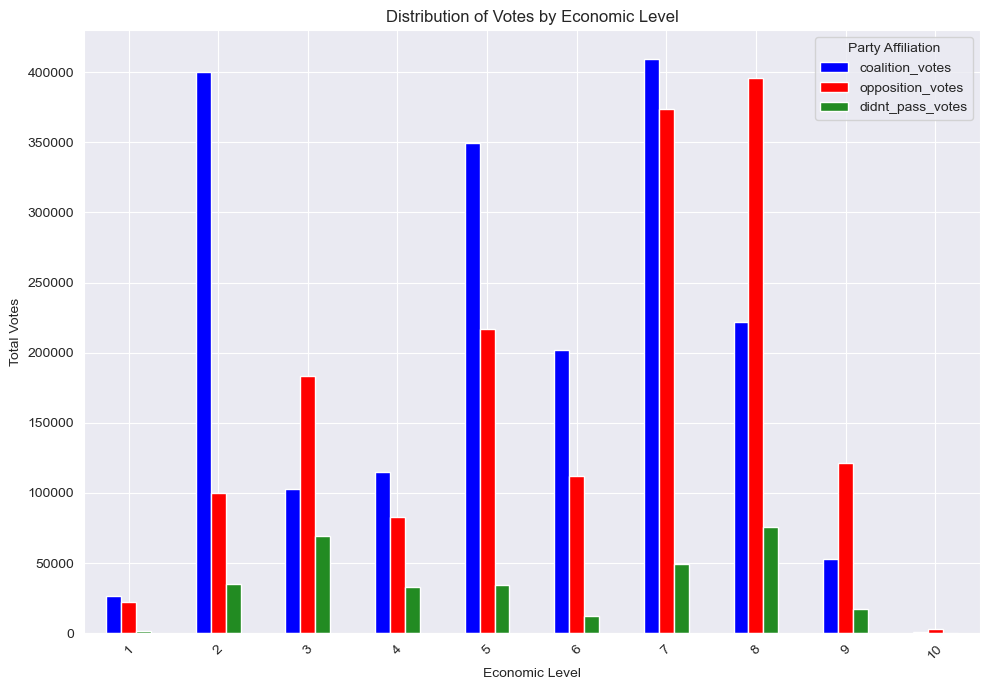

In [19]:
grouped = kalpi_socioeconomic_df.groupby('CLUSTER 2021[4]')[
    ['coalition_votes', 'opposition_votes', 'didnt_pass_votes']].sum()

# Plotting the results
grouped.plot(kind='bar', stacked=False, figsize=(10, 7), color=['blue', 'red', 'forestgreen'])
plt.title('Distribution of Votes by Economic Level')
plt.xlabel('Economic Level')
plt.ylabel('Total Votes')
plt.xticks(rotation=45)
plt.legend(title='Party Affiliation')
plt.tight_layout()
plt.show()

# Creating a Model
Having reviewed our data we'd like to use machine learning in order to create a prediction model for the socioeconomic classification based on the data we accumulated so far.

When create our model we'll reduce biases by only taking the votes for each party, and normalizing them by the total valid votes (These will be our features). Our target will be the socioeconomic classification.

In [7]:
socioeconomic_prediction_df = kalpi_socioeconomic_df.iloc[:, 11:51].div(kalpi_socioeconomic_df.iloc[:, 10], axis=0)

socioeconomic_prediction_df['CLUSTER 2021[4]'] = kalpi_socioeconomic_df['CLUSTER 2021[4]']
socioeconomic_prediction_df.head()

,אמת,אצ,ב,ג,ד,ום,ז,זך,זנ,זץ,...,ץ,ק,קי,קך,קנ,קץ,רז,שס,ת,CLUSTER 2021[4]
4,0.002833,0.0,0.0,0.0,0.484419,0.121813,0.0,0.0,0.0,0.0,...,0.002833,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,3
5,0.009119,0.0,0.0,0.0,0.416413,0.121581,0.0,0.0,0.0,0.0,...,0.003040,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.003040,0.0,3
6,0.006231,0.0,0.0,0.0,0.548287,0.112150,0.0,0.0,0.0,0.0,...,0.009346,0.003115,0.0,0.003115,0.0,0.003115,0.0,0.000000,0.0,3
7,0.002874,0.0,0.0,0.0,0.399425,0.094828,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.005747,0.0,3
8,0.000000,0.0,0.0,0.0,0.401575,0.086614,0.0,0.0,0.0,0.0,...,0.003937,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,3


The features and target will be seperated to train and test sets. We'll use Random Forest Classifier in order to build our model. 

In [8]:
X = socioeconomic_prediction_df.drop('CLUSTER 2021[4]', axis=1)
y = socioeconomic_prediction_df['CLUSTER 2021[4]']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize and train the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Initialize and train the Majority Class Classifier (Baseline)
majority_clf = DummyClassifier(strategy='stratified')
majority_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [10]:

# Predict probabilities for Majority Class Classifier
y_prob_majority = majority_clf.predict_proba(X_test)

We'll plot the ROC curve for each class using the One-vs_Rest method.

In [11]:
def plot_roc_curve_multiclass(y_test, y_prob, title):

    # Binarize the labels for One-vs-Rest evaluation
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)

    # Initialize the plot
    plt.figure(figsize=(10, 8))

    # Plot the ROC curve for each class
    for i, class_label in enumerate(lb.classes_):
        # Calculate ROC curve for each class
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot each ROC curve
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

    # Add a micro-average ROC curve
    y_test_micro = y_test_binarized.ravel()
    y_prob_micro = y_prob.ravel()
    fpr_micro, tpr_micro, _ = roc_curve(y_test_micro, y_prob_micro)
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average (AUC = {roc_auc_micro:.2f})', linestyle=':', color='black')

    # Plot diagonal line for random guessing
    plt.plot([0, 1], [0, 1], 'k--')

    # Plot formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    

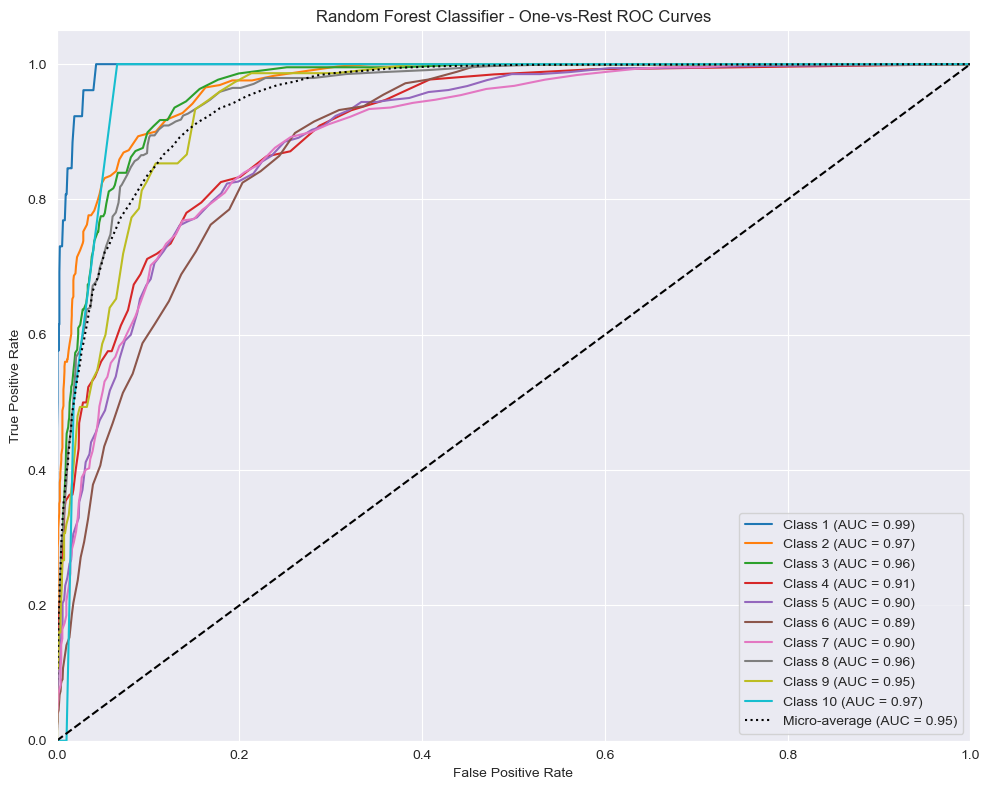

In [12]:
y_prob_rf = rf_clf.predict_proba(X_test)
plot_roc_curve_multiclass(y_test, y_prob_rf, 'Random Forest Classifier - One-vs-Rest ROC Curves')

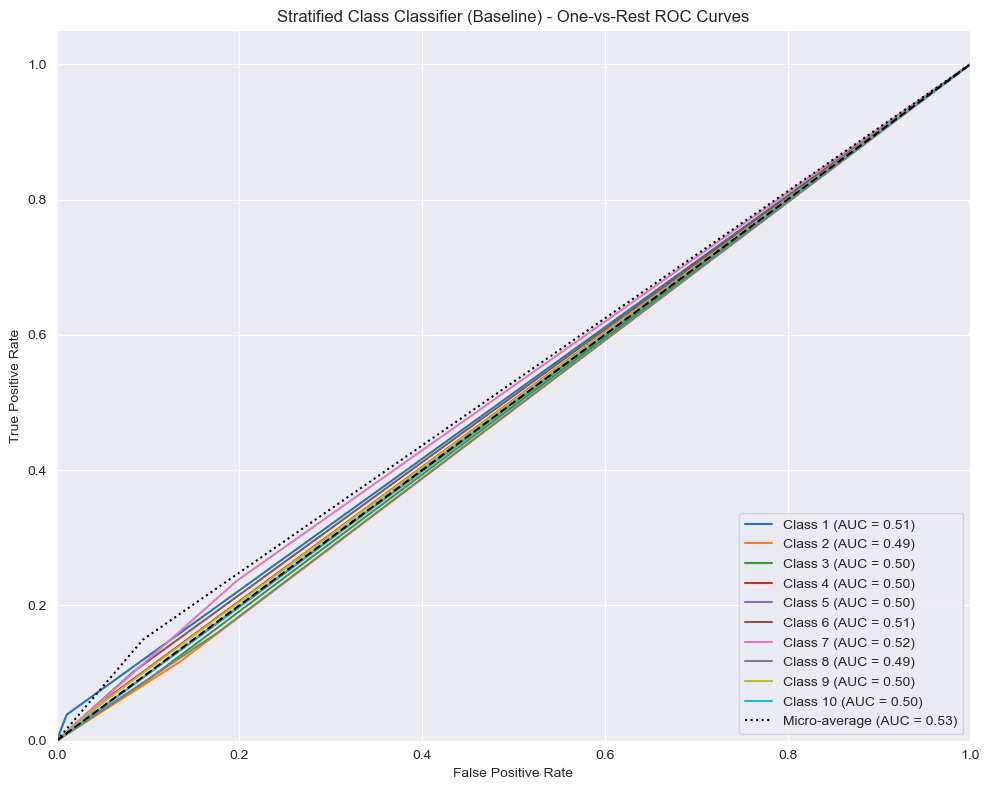

In [20]:
# Plot ROC curves for Majority Class Classifier
y_prob_majority = majority_clf.predict_proba(X_test)
plot_roc_curve_multiclass(y_test, y_prob_majority, title='Stratified Class Classifier (Baseline) - One-vs-Rest ROC Curves')

# Hyperparameter Optimization
In order to improve our model we'll use an hyperparameter optimization to increase our results.

We chose to use the Grid search algorithm in order to increase our performance. 
The parameters we cose to optimize are: 'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'
We used 5-fold cross-validation and used a One-vs-Rest ROC AUC for the scoring.

In [14]:
lb = LabelBinarizer()
y_train_binarized = lb.fit_transform(y_train)

# Define the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a scorer based on ROC AUC
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=param_grid,
                           scoring=roc_auc_scorer,
                           cv=5,  
                           verbose=2,
                           n_jobs=-1)  

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr),
             verbose=2)

Finally we received that the following parameters performed best.

In [15]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score from CV:", best_score)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best ROC AUC Score from CV: 0.9333107791011036


We'll evaluate the best estimator on the test set and receive:

In [16]:
best_rf_clf = grid_search.best_estimator_
y_prob = best_rf_clf.predict_proba(X_test)
y_test_binarized = lb.transform(y_test)

# Calculate ROC AUC on the test set
roc_auc_test = roc_auc_score(y_test_binarized, y_prob)
print("ROC AUC Score on Test Set:", roc_auc_test)

ROC AUC Score on Test Set: 0.9407695302219634


Finally, we'll polt the ROC AUC curves for the model after hyperparameter optimization.

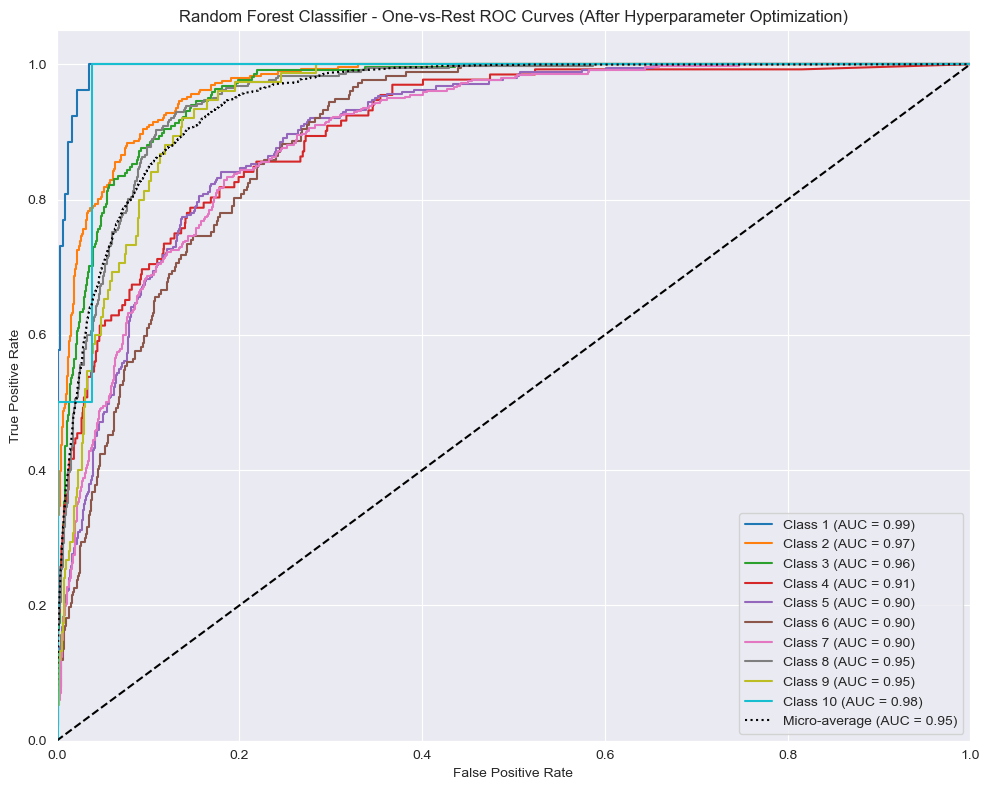

In [17]:
plot_roc_curve_multiclass(y_test, y_prob, 'Random Forest Classifier - One-vs-Rest ROC Curves (After Hyperparameter Optimization)')

For further data, we'll analyze the feature importance in our random forest model. 

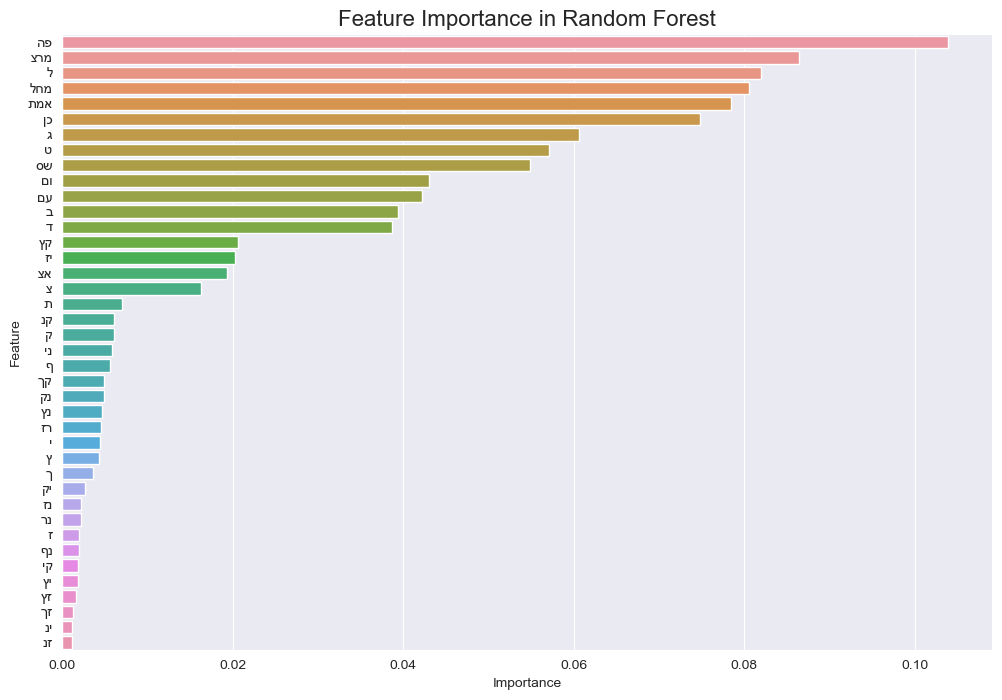

In [18]:
feature_importances = best_rf_clf.feature_importances_
feature_names = X.columns


# Flip the letters in each feature name (reverse the string)
flipped_feature_names = [feature[::-1] for feature in feature_names]

# Create a DataFrame for feature importances with flipped feature names
feature_df = pd.DataFrame({
    'Feature': flipped_feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title('Feature Importance in Random Forest', fontsize=16)

plt.show()